# A computational method for optimal selection of Kernel Density Estimator bandwidth

In this work we propose a computational method for optimal selection of Kernel Density Estimator (KDE) bandwidth based on a Mean Squared Error (MSE) cross-validation process.

The need for a custom computational method not based on an analytical approach is caused by the inefficiency of existing analytical approaches to describe the actual data at hand in this research.

## Import required libraries

In [15]:
# General Python libraries required
import pandas as pd
import numpy as np
import math
import scipy.stats as st
import os

import matplotlib.pyplot as plt
from matplotlib import rc

from sklearn.neighbors import KernelDensity
from pathlib import Path

# Get current working directory path for the tool parent folder and print it.
parent_folder = 'Tool'
cwd = str(Path(os.getcwd()[:os.getcwd().index(parent_folder)+len(parent_folder)]))
print('Parent working directory: %s' % cwd)

# Import custom libraries from local folder.
import sys
sys.path.append("..")
from library.irplib.main import nbins, order_of_magnitude
from library.irplib import irpplots

Parent working directory: /Users/jjrr/Documents/SCA-Project/Tool


## Set-up visualization options for pandas and matplotlib

In [4]:
# Import matplotlib library and setup environment for plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
 
# Set pandas DataFrame visualization parameters
pd.options.display.max_columns = None

# Set rendering parameters to use TeX font if not working on Juno app.
if not '/private/var/' in os.getcwd():
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 11})
    rc('text', usetex=True)

## Import dataset

In [5]:
# Import training dataset
df = pd.read_csv(os.path.join(cwd,'data','esa-challenge','train_data.csv'), 
                 sep=',', header=0, index_col=None, skipinitialspace=False)

# Sort values of dataframe by event_id and time_to_tca and re-index
df.sort_values(by=['event_id', 'time_to_tca'], axis='index', 
               ascending=[True,False], inplace=True, ignore_index=True)

# Show first n rows of dataframe
# df.head(10)

# Get only last CDM data from every event_id
df_lastCDM = df.drop_duplicates('event_id', keep='last')

# Show first n rows of dataframe with only final CDMs.
df_lastCDM.head(6)


,event_id,time_to_tca,mission_id,risk,max_risk_estimate,max_risk_scaling,miss_distance,relative_speed,relative_position_r,relative_position_t,relative_position_n,relative_velocity_r,relative_velocity_t,relative_velocity_n,t_time_lastob_start,t_time_lastob_end,t_recommended_od_span,t_actual_od_span,t_obs_available,t_obs_used,t_residuals_accepted,t_weighted_rms,t_rcs_estimate,t_cd_area_over_mass,t_cr_area_over_mass,t_sedr,t_j2k_sma,t_j2k_ecc,t_j2k_inc,t_ct_r,t_cn_r,t_cn_t,t_crdot_r,t_crdot_t,t_crdot_n,t_ctdot_r,t_ctdot_t,t_ctdot_n,t_ctdot_rdot,t_cndot_r,t_cndot_t,t_cndot_n,t_cndot_rdot,t_cndot_tdot,c_object_type,c_time_lastob_start,c_time_lastob_end,c_recommended_od_span,c_actual_od_span,c_obs_available,c_obs_used,c_residuals_accepted,c_weighted_rms,c_rcs_estimate,c_cd_area_over_mass,c_cr_area_over_mass,c_sedr,c_j2k_sma,c_j2k_ecc,c_j2k_inc,c_ct_r,c_cn_r,c_cn_t,c_crdot_r,c_crdot_t,c_crdot_n,c_ctdot_r,c_ctdot_t,c_ctdot_n,c_ctdot_rdot,c_cndot_r,c_cndot_t,c_cndot_n,c_cndot_rdot,c_cndot_tdot,t_span,c_span,t_h_apo,t_h_per,c_h_apo,c_h_per,geocentric_latitude,azimuth,elevation,mahalanobis_distance,t_position_covariance_det,c_position_covariance_det,t_sigma_r,c_sigma_r,t_sigma_t,c_sigma_t,t_sigma_n,c_sigma_n,t_sigma_rdot,c_sigma_rdot,t_sigma_tdot,c_sigma_tdot,t_sigma_ndot,c_sigma_ndot,F10,F3M,SSN,AP
4,0,0.257806,5,-10.391260,-7.852942,9.036838,14510.0,13792.0,478.7,5811.1,-13288.0,-7.0,-12637.0,-5525.9,1.0,0.0,3.86,3.86,440,439,98.8,1.340,0.4020,0.013906,0.007339,0.000068,6996.920446,0.003996,97.806426,0.417865,0.406002,0.246911,-0.465256,-0.983144,-0.243006,-0.999749,-0.430895,-0.405723,0.479990,0.223469,0.118674,0.543475,-0.143542,-0.224060,UNKNOWN,180.0,2.0,15.85,15.85,15.0,15.0,100.0,2.360,NaN,0.348701,0.126607,0.001406,7006.626646,0.003144,74.045736,-0.815980,0.485794,-0.004081,0.816347,-0.999998,0.005077,-0.727257,0.196662,-0.818575,-0.197284,0.261753,0.195657,0.721794,-0.195947,-0.677041,1.0,2.0,646.745868,590.821024,650.519613,606.459678,-73.570409,-23.618769,0.029079,469.178802,7.827098e+03,4.374142e+16,3.392176,260.727425,16.110807,54063.675421,1.958295,46.594699,0.015075,57.946717,0.003670,0.164172,0.003220,0.386388,89.0,83.0,40.0,14.0
8,1,3.570013,5,-9.248105,-7.327533,7.425994,26899.0,3434.0,-82.0,-26067.0,6638.2,56.8,-847.8,-3328.2,1.0,0.0,4.04,4.04,430,429,99.0,1.402,0.4030,0.015178,0.003417,0.000031,7001.561205,0.001028,97.767002,0.025433,0.318842,0.027919,-0.050648,-0.997384,-0.040625,-0.999560,-0.053437,-0.319966,0.079098,0.016432,-0.049850,0.760496,0.046685,-0.015341,DEBRIS,1.0,0.0,3.54,3.55,33.0,33.0,100.0,1.650,0.0045,0.151857,0.000000,0.008730,6880.588349,0.017491,82.431524,-0.896007,-0.341763,0.075631,0.895993,-1.000000,-0.075170,-0.982560,0.962694,0.243049,-0.962685,-0.389578,0.249596,0.811324,-0.249363,0.344542,1.0,2.0,630.622566,616.225845,622.796659,382.106039,-54.109782,-75.708851,-0.947480,62.058087,5.097272e+06,8.825836e+15,5.455330,99.916400,115.552629,27824.072312,3.780796,97.159318,0.124802,30.242768,0.005883,0.174956,0.003408,0.058311,71.0,87.0,21.0,5.0
28,2,0.401947,2,-30.000000,-7.449283,37296.168207,18708.0,14347.0,-717.9,-5159.0,17968.9,14.4,-13791.4,-3957.2,1.0,0.0,3.56,3.56,481,481,99.1,1.056,3.4479,0.019441,0.014506,0.000013,7158.408492,0.000863,98.523055,0.170637,0.077322,0.044859,-0.301307,-0.945516,-0.007249,-0.999839,-0.187388,-0.076980,0.317338,0.101294,0.042436,-0.524384,-0.042744,-0.102280,UNKNOWN,1.0,0.0,14.56,14.56,18.0,18.0,100.0,1.733,NaN,0.858056,0.474456,0.000591,7168.395415,0.001298,69.718579,-0.733858,0.811887,-0.712991,0.677382,-0.935640,0.552588,-0.999956,0.728830,-0.812411,-0.671514,0.854603,-0.742879,0.966785,0.540052,-0.855151,12.0,2.0,786.448033,774.094951,799.560390,780.956440,63.902737,-16.009902,-0.057504,279.634916,1.440938e+03,1.080252e+12,2.800282,101.046821,9.139996,231.198248,1.510495,117.423294,0.009590,0.219821,0.002918,0.105403,0.002903,0.290009,70.0,77.0,0.0,4.0
49,3,0.283061,19,-30.000000,-8.439735,45859.719269,23861.0,13574.0,51.8,10055.9,21639.4,-39.6,-12310.9,5

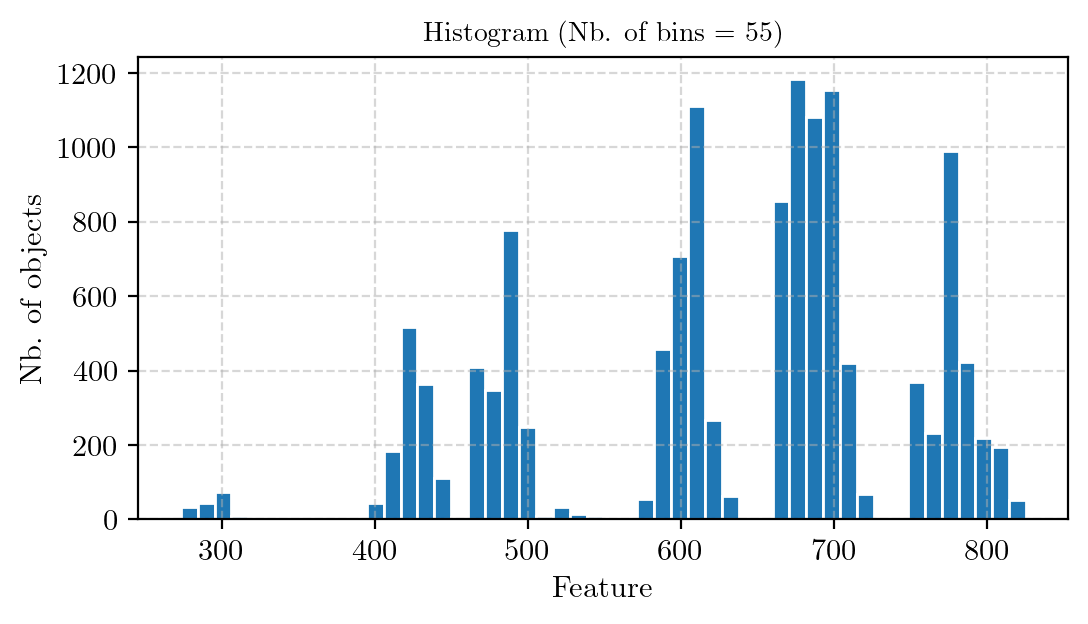

In [6]:
# data = sample
data = df_lastCDM['t_h_per'].to_numpy()

bins = main.nbins(data, 'fd')

plt.figure(figsize=(6,3))
plt.hist(data, bins=50, ec='white')
plt.xlabel('Feature')
plt.ylabel('Nb. of objects')
plt.title('Histogram (Nb. of bins = %d)' % bins['n'], fontsize=10)
plt.grid(True, linestyle="dashed", alpha=0.5)
plt.show()

## Optimal bandwidth selection using Minimum Squared Error cross-validation (MSECV)

In [7]:
# Define function to compute KDE
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(np.array(x).reshape(-1,1))
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    
    return np.exp(log_pdf)

In [13]:
def bandwidth_msecv(data: np.ndarray, tol:float = 1e-5, print_log:bool = True) -> dict:

    bins = nbins(data, 'fd')

    # Create cluster array to get batches of data
    n_samples = np.arange(start=2, stop=11, step=1, dtype=np.int32)
    best_bws = np.zeros(len(n_samples))

    for i, n_clusters in enumerate(n_samples):
        if print_log: print(f'Total batches = {n_clusters} ({len(data)//n_clusters} data points per batch)')

        clusters = np.random.randint(low=0, high=n_clusters, size=len(data))

        # Initialize array to store actual probabilty densities (apds)
        apds = np.zeros((bins['n'], n_clusters))

        for j in range(n_clusters):
            sample = data[clusters==j]

            apd, bin_edges = np.histogram(sample, bins = bins['n'], density=True)
            apds[:,j] = apd

        # Compute bin centers to which the density computed shall be linked
        bin_centers = bin_edges[:-1] + bins['width']/2

        # Compute average of all actual probability densities computed
        avg_apd = np.mean(apds, axis=1, dtype=np.float64)

        # Initialize bandwidth and MSE arrays
        bandwidths, step = np.linspace(bins['width']/100, bins['width'], 100, retstep=True)

        best_bw = np.inf
        while True:

            mse = np.zeros(len(bandwidths))

            for b, bandwidth in enumerate(bandwidths):

                epd = kde_sklearn(data, bin_centers, kernel='gaussian', bandwidth=bandwidth)
                mse[b] = ((epd - avg_apd)**2).mean()

            bw = bandwidths[mse==mse.min()][0]

            # print(f'  New bandwidth: {bw:.4e} MSE: {mse.min():.5e}')
            if abs(1 - best_bw/bw) <= tol: break 

            bandwidths, step = np.linspace(bw-step, bw+step, 100, retstep = True)
            best_bw = bw

        best_bws[i] = best_bw 

        if print_log: print(f'Best bandwidth = {best_bw:.5f} \nMSE = {mse.min():.4e}\n')

    scale = 10**order_of_magnitude(best_bws.mean())
    best_bw = (math.ceil(best_bws.mean()/scale)*scale)
    
    if print_log: print(f'Final Optimal bandwidth = {best_bw}')
    
    # Compute final estimated probability density using the best bandwidth
    epd = kde_sklearn(data, bin_centers, kernel='gaussian', bandwidth=best_bw)
    
    return {'bw': best_bw, 'mse':((epd - avg_apd)**2).mean(), 
            'avg_apd': avg_apd, 'bin_centers': bin_centers}

In [ ]:
def plot_mse_bw(bandwidths, mse):
    
    # Plot MSE vs bandwidth
    plt.figure(figsize=(6,3))
    plt.plot(bandwidths, mse, '--')
    plt.plot(bandwidths[mse==mse.min()][0], mse.min(), 'ro', label = f'BW = {best_bw:.4f}')
    plt.xlabel('Bandwidth', fontsize=10)
    plt.ylabel('Mean Squared Error (MSE)', fontsize=10)
    plt.title('Bandwidth selection using MSE cross-validation', fontsize=12)
    plt.grid(True, linestyle="dashed", alpha=0.5)
    plt.legend(loc='best')
    plt.show()
    
    return

Total batches = 2 (6577 data points per batch)
Best bandwidth = 3.44003 
MSE = 9.7578e-08

Total batches = 3 (4384 data points per batch)
Best bandwidth = 3.42779 
MSE = 1.0160e-07

Total batches = 4 (3288 data points per batch)
Best bandwidth = 3.51373 
MSE = 3.4800e-08

Total batches = 5 (2630 data points per batch)
Best bandwidth = 3.44020 
MSE = 9.0664e-08

Total batches = 6 (2192 data points per batch)
Best bandwidth = 3.93823 
MSE = 3.4794e-07

Total batches = 7 (1879 data points per batch)
Best bandwidth = 3.47290 
MSE = 1.2371e-07

Total batches = 8 (1644 data points per batch)
Best bandwidth = 4.24745 
MSE = 9.0920e-08

Total batches = 9 (1461 data points per batch)
Best bandwidth = 3.58520 
MSE = 1.3638e-07

Total batches = 10 (1315 data points per batch)
Best bandwidth = 3.69235 
MSE = 3.0289e-08

Final Optimal bandwidth = 4


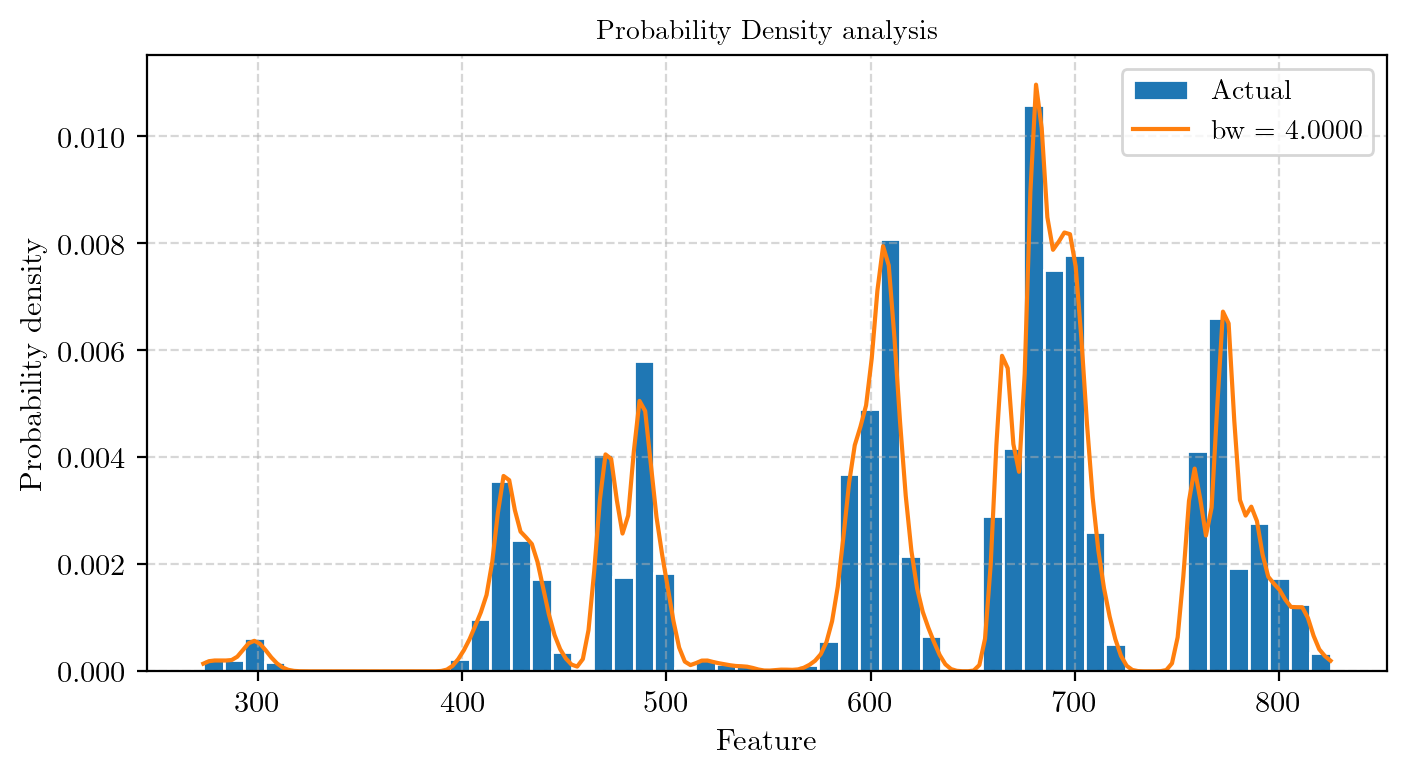

Total batches = 2 (6577 data points per batch)
Best bandwidth = 3.03450 
MSE = 3.8421e-07

Total batches = 3 (4384 data points per batch)
Best bandwidth = 3.02217 
MSE = 2.7096e-07

Total batches = 4 (3288 data points per batch)
Best bandwidth = 3.01576 
MSE = 3.7807e-07

Total batches = 5 (2630 data points per batch)
Best bandwidth = 3.22342 
MSE = 7.8830e-07

Total batches = 6 (2192 data points per batch)
Best bandwidth = 3.07415 
MSE = 3.5648e-07

Total batches = 7 (1879 data points per batch)
Best bandwidth = 3.26210 
MSE = 6.5702e-08

Total batches = 8 (1644 data points per batch)
Best bandwidth = 3.31996 
MSE = 4.2889e-07

Total batches = 9 (1461 data points per batch)
Best bandwidth = 3.49519 
MSE = 1.3516e-07

Total batches = 10 (1315 data points per batch)
Best bandwidth = 3.08331 
MSE = 2.2579e-07

Final Optimal bandwidth = 4


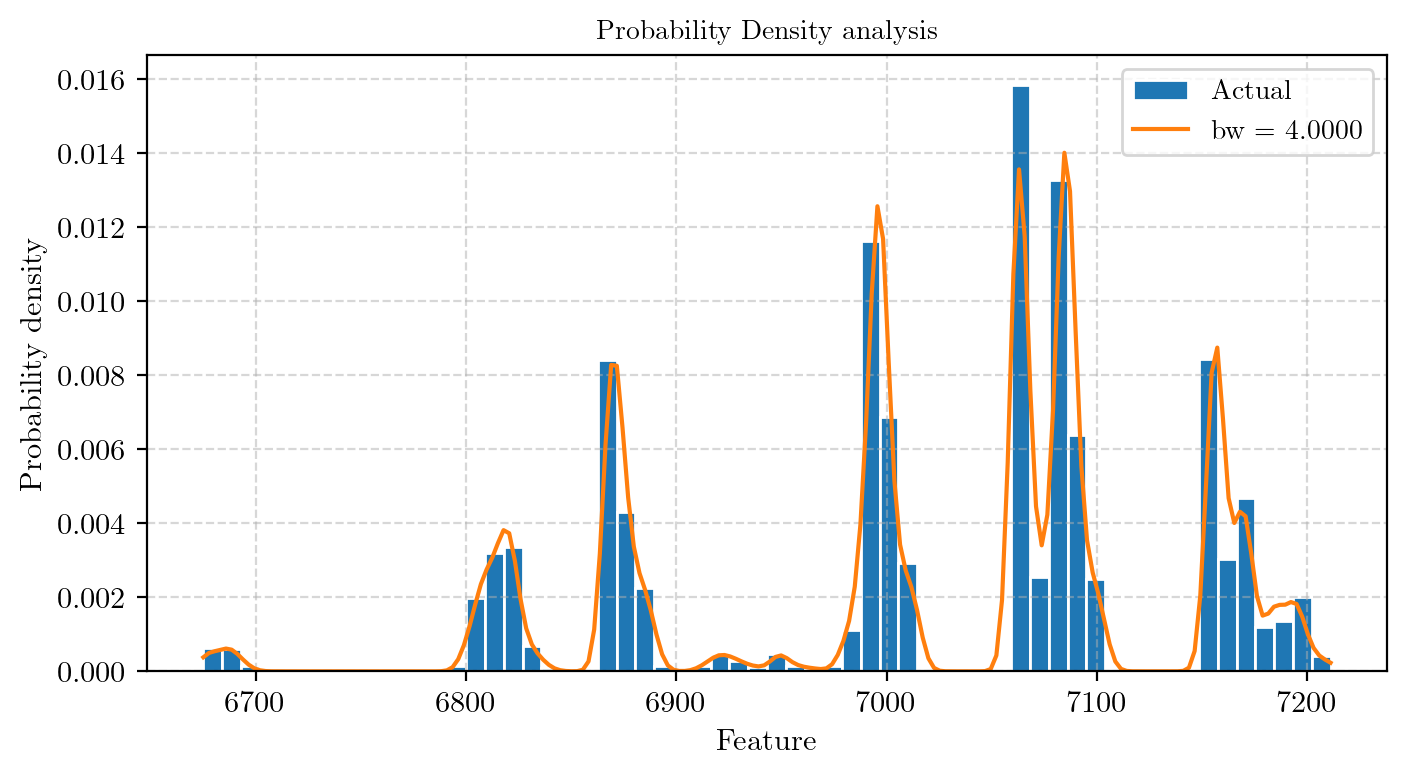

Total batches = 2 (6577 data points per batch)
Best bandwidth = 0.20050 
MSE = 5.2953e-04

Total batches = 3 (4384 data points per batch)
Best bandwidth = 0.20097 
MSE = 5.1843e-04

Total batches = 4 (3288 data points per batch)
Best bandwidth = 0.19844 
MSE = 5.3927e-04

Total batches = 5 (2630 data points per batch)
Best bandwidth = 0.19996 
MSE = 5.3109e-04

Total batches = 6 (2192 data points per batch)
Best bandwidth = 0.19996 
MSE = 5.5694e-04

Total batches = 7 (1879 data points per batch)
Best bandwidth = 0.20119 
MSE = 5.7106e-04

Total batches = 8 (1644 data points per batch)
Best bandwidth = 0.19962 
MSE = 5.5588e-04

Total batches = 9 (1461 data points per batch)
Best bandwidth = 0.20107 
MSE = 5.7999e-04

Total batches = 10 (1315 data points per batch)
Best bandwidth = 0.19691 
MSE = 5.4865e-04

Final Optimal bandwidth = 0.2


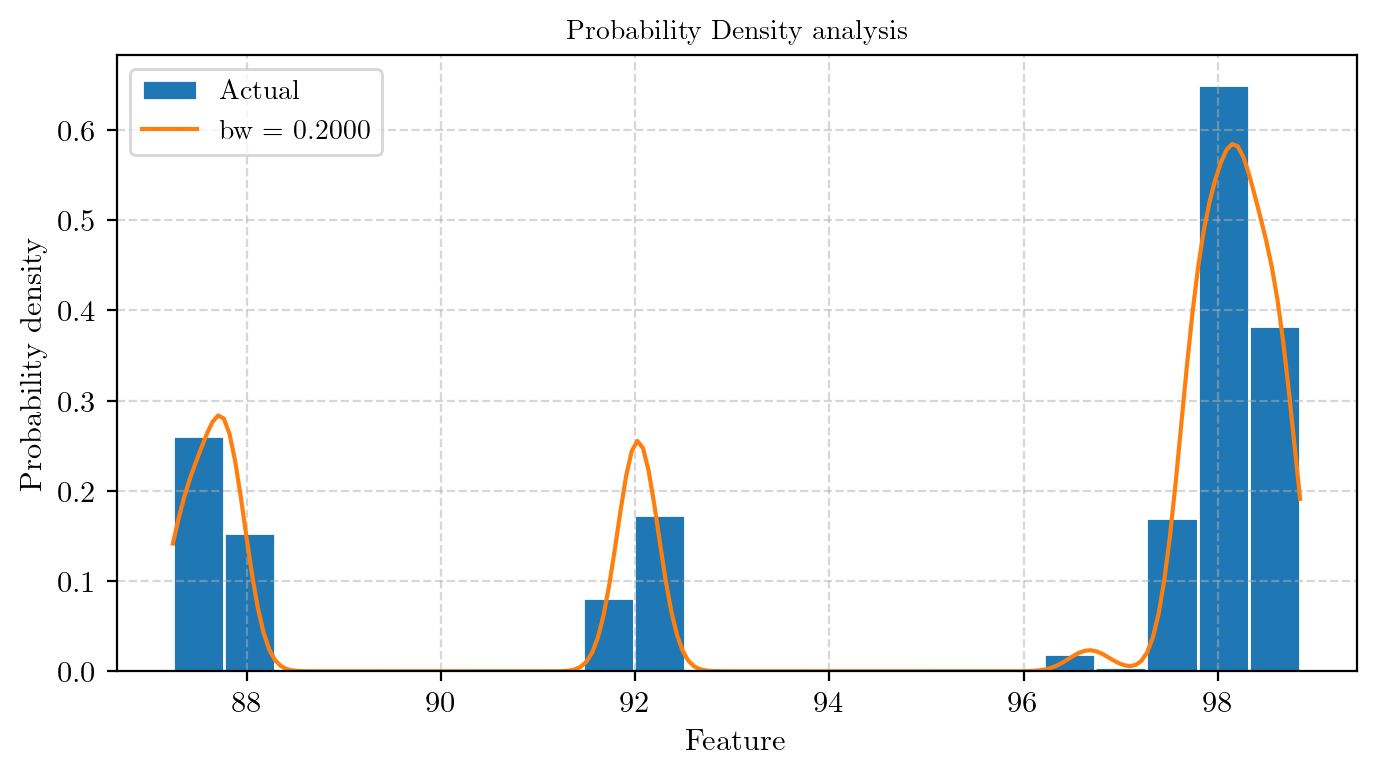

Total batches = 2 (6577 data points per batch)
Best bandwidth = 0.00005 
MSE = 2.9746e+01

Total batches = 3 (4384 data points per batch)
Best bandwidth = 0.00004 
MSE = 6.0999e+02

Total batches = 4 (3288 data points per batch)
Best bandwidth = 0.00005 
MSE = 1.2717e+02

Total batches = 5 (2630 data points per batch)
Best bandwidth = 0.00006 
MSE = 1.3559e+01

Total batches = 6 (2192 data points per batch)
Best bandwidth = 0.00008 
MSE = 1.3287e+02

Total batches = 7 (1879 data points per batch)
Best bandwidth = 0.00009 
MSE = 1.1253e+02

Total batches = 8 (1644 data points per batch)
Best bandwidth = 0.00011 
MSE = 6.4530e+02

Total batches = 9 (1461 data points per batch)
Best bandwidth = 0.00006 
MSE = 3.5275e+01

Total batches = 10 (1315 data points per batch)
Best bandwidth = 0.00009 
MSE = 1.7129e+02

Final Optimal bandwidth = 8e-05


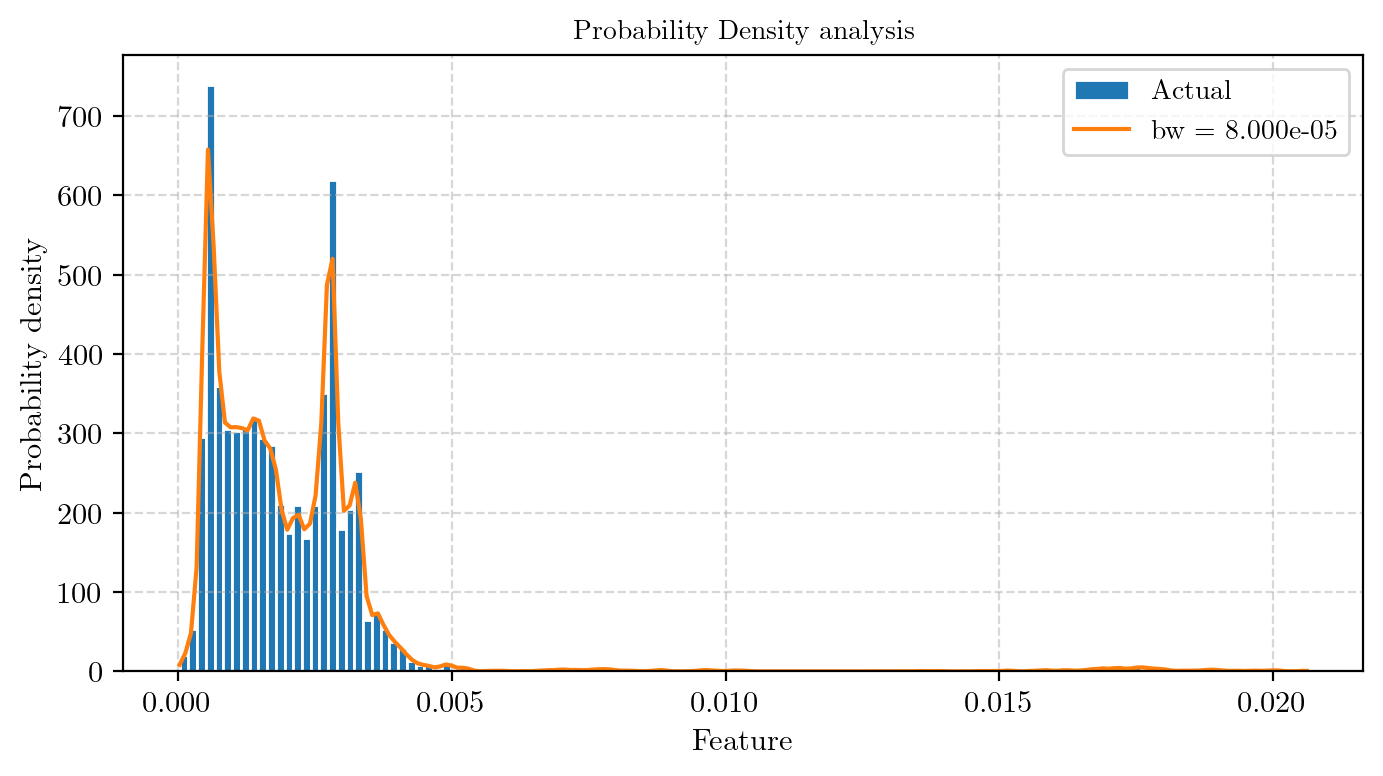

Total batches = 2 (6577 data points per batch)
Best bandwidth = 2.90825 
MSE = 2.7467e-07

Total batches = 3 (4384 data points per batch)
Best bandwidth = 5.93085 
MSE = 4.4040e-07

Total batches = 4 (3288 data points per batch)
Best bandwidth = 6.48836 
MSE = 1.7753e-06

Total batches = 5 (2630 data points per batch)
Best bandwidth = 6.48836 
MSE = 1.2966e-06

Total batches = 6 (2192 data points per batch)
Best bandwidth = 6.48836 
MSE = 2.5727e-07

Total batches = 7 (1879 data points per batch)
Best bandwidth = 6.48836 
MSE = 5.7402e-07

Total batches = 8 (1644 data points per batch)
Best bandwidth = 6.48836 
MSE = 4.4767e-07

Total batches = 9 (1461 data points per batch)
Best bandwidth = 6.48836 
MSE = 1.7930e-06

Total batches = 10 (1315 data points per batch)
Best bandwidth = 6.48836 
MSE = 4.3208e-07

Final Optimal bandwidth = 7


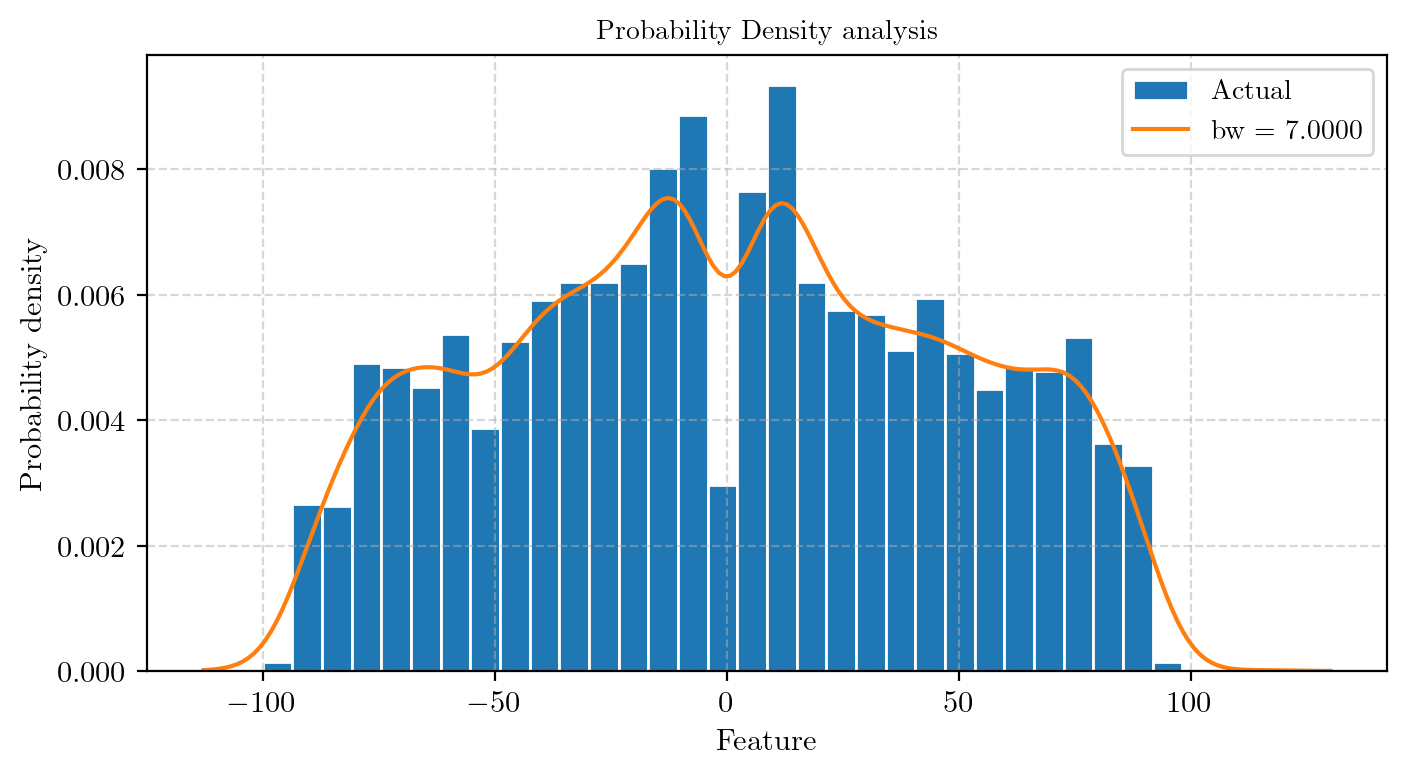

In [24]:
# Features to approximate t_h_per, t_j2k_sma, t_j2k_inc, t_j2k_ecc
features = ['t_h_per', 't_j2k_sma', 't_j2k_inc', 't_j2k_ecc', 'azimuth']

for feature in features:
    # feature = features[4]
    data = df_lastCDM[feature].to_numpy()

    # Shuffle data
    np.random.shuffle(data)
    
    # Get resulsts from the cross-validation
    kde_bw = bandwidth_msecv(data) 

#     kde_x_grid = np.linspace(kde_bw['bin_centers'][0], kde_bw['bin_centers'][-1],1000)
#     epd = kde_sklearn(data, kde_x_grid, kernel='gaussian', bandwidth=kde_bw['bw'])

#     plt.figure(figsize=(8,4))
#     plt.plot(kde_bw['bin_centers'], kde_bw['avg_apd'], label = r'Actuals average')
#     plt.plot(kde_x_grid, epd, label = r'Estimated')
#     plt.xlabel('Feature')
#     plt.ylabel('Probability density')
#     plt.title('Probability density (Nb. bins = %d)' % bins['n'], fontsize=10)
#     plt.grid(True, linestyle="dashed", alpha=0.5)
#     plt.legend(loc='best', fontsize=10)
#     plt.show()

    irpplots.plot_kde(data, [kde_bw['bw']], figsize=(8,4))

